In [9]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import time
import copy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

In [10]:
# --- [✨ 추가] 최종 테스트 평가 함수 ---
def evaluate_model_on_test_set(model, test_loader, device, class_names, model_path):
    """
    학습이 완료된 후 저장된 최적의 모델을 불러와
    test 데이터셋으로 최종 성능을 평가하고, 결과를 시각화합니다.
    """
    # 저장된 최적의 가중치를 모델에 로드
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()  # 모델을 평가 모드로 설정

    all_preds = []
    all_labels = []
    running_loss = 0.0
    running_corrects = 0
    criterion = nn.CrossEntropyLoss()

    print("\n--- 최종 모델 성능 평가 (Test Set) ---")
    
    with torch.no_grad(): # 그래디언트 계산 비활성화
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
            # 나중에 confusion matrix와 classification report를 위해 예측값과 실제값 저장
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # 전체 테스트 데이터에 대한 손실과 정확도
    test_loss = running_loss / len(test_loader.dataset)
    test_acc = running_corrects.double() / len(test_loader.dataset)
    print(f"\n✅ Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}\n")

    # --- Classification Report 출력 ---
    print("📋 Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))

    # --- Confusion Matrix 시각화 ---
    print("📊 Confusion Matrix:")
    cm = confusion_matrix(all_labels, all_preds)
    df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    
    # ✨ --- 한글 폰트 설정 시작 --- ✨
    try:
        import matplotlib.pyplot as plt
        # Windows 운영체제의 경우
        plt.rc('font', family='Malgun Gothic')
    except ImportError:
        print("matplotlib 라이브러리를 찾을 수 없습니다.")
    except Exception as e:
        print(f"폰트 설정 중 오류 발생: {e}")
        print("macOS는 'AppleGothic', Linux는 'NanumGothic'을 시도해 보세요.")

    # 마이너스 기호가 깨지는 것을 방지
    plt.rcParams['axes.unicode_minus'] = False
    # ✨ --- 한글 폰트 설정 종료 --- ✨

    plt.figure(figsize=(10, 7))
    sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix', fontsize=16) # 타이틀 폰트 크기 조절
    plt.xlabel('Predicted Label', fontsize=12) # x축 라벨 폰트 크기 조절
    plt.ylabel('True Label', fontsize=12) # y축 라벨 폰트 크기 조절
    plt.show()


In [11]:
def train_model(model, criterion, optimizer, scheduler, num_epochs, dataloaders, device, model_save_path):
    """EfficientNet 모델을 학습하고 검증하는 메인 함수"""
    start_time = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            progress_bar = tqdm(dataloaders[phase], desc=f"{phase.capitalize()} Phase")

            for inputs, labels in progress_bar:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    with torch.cuda.amp.autocast():
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                    if phase == 'train':
                        scaler.scale(loss).backward()
                        scaler.step(optimizer)
                        scaler.update()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                progress_bar.set_postfix(loss=f'{loss.item():.4f}')

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            print(f'✅ {phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), model_save_path)
                print(f'🚀 Best validation accuracy updated: {best_acc:.4f}, Model saved!')

    time_elapsed = time.time() - start_time
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'🏆 Best val Acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)
    return model


Using device: cuda

--- 데이터셋 상세 정보 ---

✅ Train Dataset: 총 19602개
  - 단호박점무늬병: 7576개
  - 단호박흰가루병: 6426개
  - 정상: 5600개

✅ Val Dataset: 총 2483개
  - 단호박점무늬병: 947개
  - 단호박흰가루병: 836개
  - 정상: 700개

✅ Test Dataset: 총 2486개
  - 단호박점무늬병: 948개
  - 단호박흰가루병: 838개
  - 정상: 700개
---------------------------

Class names: ['단호박점무늬병', '단호박흰가루병', '정상']
Number of classes: 3


C:\Users\427s2\AppData\Local\Temp\ipykernel_10828\1756973827.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Epoch 1/15
----------


Train Phase:   0%|          | 0/613 [00:00<?, ?it/s]C:\Users\427s2\AppData\Local\Temp\ipykernel_10828\1756973827.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Train Phase: 100%|██████████| 613/613 [05:50<00:00,  1.75it/s, loss=0.0139]


✅ train Loss: 0.0926 Acc: 0.9732


Val Phase: 100%|██████████| 78/78 [00:58<00:00,  1.33it/s, loss=0.0006]


✅ val Loss: 0.0118 Acc: 0.9972
🚀 Best validation accuracy updated: 0.9972, Model saved!
Epoch 2/15
----------


Train Phase: 100%|██████████| 613/613 [05:55<00:00,  1.73it/s, loss=0.0071]


✅ train Loss: 0.0466 Acc: 0.9868


Val Phase: 100%|██████████| 78/78 [00:57<00:00,  1.35it/s, loss=0.0000]


✅ val Loss: 0.0116 Acc: 0.9964
Epoch 3/15
----------


Train Phase: 100%|██████████| 613/613 [05:40<00:00,  1.80it/s, loss=0.0030]


✅ train Loss: 0.0432 Acc: 0.9873


Val Phase: 100%|██████████| 78/78 [00:59<00:00,  1.32it/s, loss=0.0002]


✅ val Loss: 0.0071 Acc: 0.9980
🚀 Best validation accuracy updated: 0.9980, Model saved!
Epoch 4/15
----------


Train Phase: 100%|██████████| 613/613 [05:44<00:00,  1.78it/s, loss=0.3463]


✅ train Loss: 0.0369 Acc: 0.9891


Val Phase: 100%|██████████| 78/78 [00:59<00:00,  1.32it/s, loss=0.0000]


✅ val Loss: 0.0062 Acc: 0.9988
🚀 Best validation accuracy updated: 0.9988, Model saved!
Epoch 5/15
----------


Train Phase: 100%|██████████| 613/613 [05:40<00:00,  1.80it/s, loss=0.0007]


✅ train Loss: 0.0349 Acc: 0.9893


Val Phase: 100%|██████████| 78/78 [00:59<00:00,  1.32it/s, loss=0.0000]


✅ val Loss: 0.0063 Acc: 0.9980
Epoch 6/15
----------


Train Phase: 100%|██████████| 613/613 [05:39<00:00,  1.80it/s, loss=1.0860]


✅ train Loss: 0.0368 Acc: 0.9899


Val Phase: 100%|██████████| 78/78 [00:58<00:00,  1.33it/s, loss=0.0000]


✅ val Loss: 0.0039 Acc: 0.9992
🚀 Best validation accuracy updated: 0.9992, Model saved!
Epoch 7/15
----------


Train Phase: 100%|██████████| 613/613 [05:42<00:00,  1.79it/s, loss=0.0562]


✅ train Loss: 0.0423 Acc: 0.9876


Val Phase: 100%|██████████| 78/78 [00:58<00:00,  1.33it/s, loss=0.0000]


✅ val Loss: 0.0679 Acc: 0.9787
Epoch 8/15
----------


Train Phase: 100%|██████████| 613/613 [05:37<00:00,  1.82it/s, loss=0.0002]


✅ train Loss: 0.0188 Acc: 0.9946


Val Phase: 100%|██████████| 78/78 [00:58<00:00,  1.33it/s, loss=0.0001]


✅ val Loss: 0.0030 Acc: 0.9992
Epoch 9/15
----------


Train Phase: 100%|██████████| 613/613 [05:39<00:00,  1.81it/s, loss=0.0006]


✅ train Loss: 0.0133 Acc: 0.9961


Val Phase: 100%|██████████| 78/78 [00:59<00:00,  1.32it/s, loss=0.0000]


✅ val Loss: 0.0036 Acc: 0.9988
Epoch 10/15
----------


Train Phase: 100%|██████████| 613/613 [05:41<00:00,  1.80it/s, loss=0.0036]


✅ train Loss: 0.0122 Acc: 0.9965


Val Phase: 100%|██████████| 78/78 [00:57<00:00,  1.35it/s, loss=0.0000]


✅ val Loss: 0.0023 Acc: 0.9996
🚀 Best validation accuracy updated: 0.9996, Model saved!
Epoch 11/15
----------


Train Phase: 100%|██████████| 613/613 [05:48<00:00,  1.76it/s, loss=0.0014]


✅ train Loss: 0.0103 Acc: 0.9971


Val Phase: 100%|██████████| 78/78 [00:58<00:00,  1.33it/s, loss=0.0000]


✅ val Loss: 0.0021 Acc: 0.9992
Epoch 12/15
----------


Train Phase: 100%|██████████| 613/613 [05:40<00:00,  1.80it/s, loss=0.0001]


✅ train Loss: 0.0093 Acc: 0.9973


Val Phase: 100%|██████████| 78/78 [00:59<00:00,  1.31it/s, loss=0.0000]


✅ val Loss: 0.0012 Acc: 0.9996
Epoch 13/15
----------


Train Phase: 100%|██████████| 613/613 [05:38<00:00,  1.81it/s, loss=0.0206]


✅ train Loss: 0.0089 Acc: 0.9974


Val Phase: 100%|██████████| 78/78 [00:58<00:00,  1.33it/s, loss=0.0000]


✅ val Loss: 0.0012 Acc: 0.9996
Epoch 14/15
----------


Train Phase: 100%|██████████| 613/613 [05:41<00:00,  1.80it/s, loss=0.0001]


✅ train Loss: 0.0069 Acc: 0.9981


Val Phase: 100%|██████████| 78/78 [00:58<00:00,  1.34it/s, loss=0.0000]


✅ val Loss: 0.0005 Acc: 1.0000
🚀 Best validation accuracy updated: 1.0000, Model saved!
Epoch 15/15
----------


Train Phase: 100%|██████████| 613/613 [05:38<00:00,  1.81it/s, loss=0.0002]


✅ train Loss: 0.0069 Acc: 0.9978


Val Phase: 100%|██████████| 78/78 [00:58<00:00,  1.33it/s, loss=0.0000]


✅ val Loss: 0.0006 Acc: 1.0000

Training complete in 100m 20s
🏆 Best val Acc: 1.000000

--- 최종 모델 성능 평가 (Test Set) ---


Testing: 100%|██████████| 78/78 [00:56<00:00,  1.37it/s]



✅ Test Loss: 0.0049 | Test Acc: 0.9980

📋 Classification Report:
              precision    recall  f1-score   support

     단호박점무늬병     0.9968    0.9979    0.9974       948
     단호박흰가루병     0.9976    0.9964    0.9970       838
          정상     1.0000    1.0000    1.0000       700

    accuracy                         0.9980      2486
   macro avg     0.9981    0.9981    0.9981      2486
weighted avg     0.9980    0.9980    0.9980      2486

📊 Confusion Matrix:


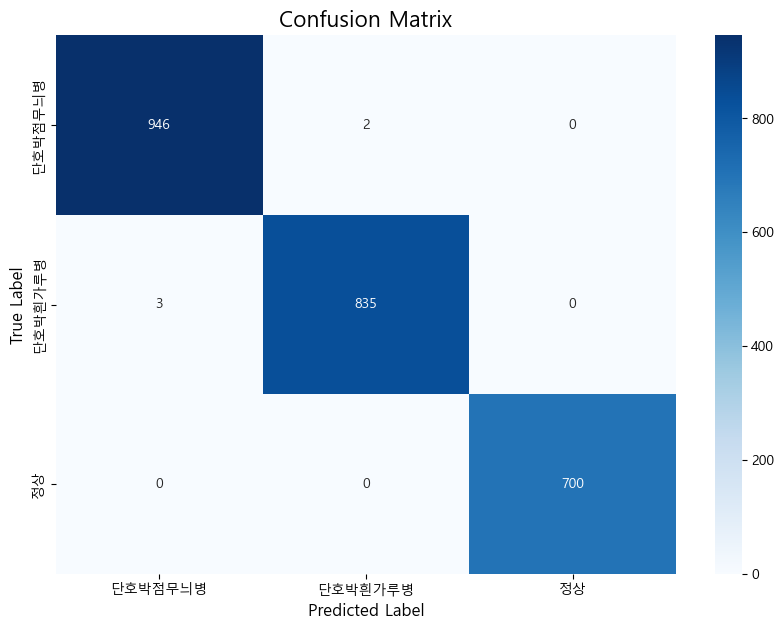

In [12]:
if __name__ == '__main__':
    # --- 1. 설정 및 하이퍼파라미터 ---
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {DEVICE}")

    DATA_PATH = r'C:\Users\427s2\KSEB\pumpkin\effinet_811_dataset'
    MODEL_SAVE_PATH = 'best_pumpkin_classifier_811.pth'
    
    IMG_SIZE = 240
    BATCH_SIZE = 32
    NUM_EPOCHS = 15
    LEARNING_RATE = 0.001

    # --- 2. 데이터 전처리 및 로더 준비 ---
    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomResizedCrop(IMG_SIZE),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize(IMG_SIZE),
            transforms.CenterCrop(IMG_SIZE),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
            transforms.Resize(IMG_SIZE),
            transforms.CenterCrop(IMG_SIZE),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }

    image_datasets = {x: datasets.ImageFolder(os.path.join(DATA_PATH, x), data_transforms[x])
                      for x in ['train', 'val', 'test']}
    
    # ==================================================================
    # ✨ [추가된 부분] 데이터셋 상세 정보 출력
    print("\n--- 데이터셋 상세 정보 ---")
    for split in ['train', 'val', 'test']:
        dataset = image_datasets[split]
        class_names_list = dataset.classes
        class_counts = {class_name: 0 for class_name in class_names_list}
        for _, label_idx in dataset.samples:
            class_name = class_names_list[label_idx]
            class_counts[class_name] += 1
        
        print(f"\n✅ {split.capitalize()} Dataset: 총 {len(dataset)}개")
        # 클래스 이름 순서가 폴더 순서에 따라 달라질 수 있으므로, 정렬해서 출력
        for class_name in sorted(class_counts.keys()):
            print(f"  - {class_name}: {class_counts[class_name]}개")
    print("---------------------------\n")
    # ==================================================================

    dataloaders = {
        'train': DataLoader(image_datasets['train'], batch_size=BATCH_SIZE, shuffle=True, num_workers=4),
        'val': DataLoader(image_datasets['val'], batch_size=BATCH_SIZE, shuffle=False, num_workers=4),
        'test': DataLoader(image_datasets['test'], batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
    }
    
    class_names = image_datasets['train'].classes
    NUM_CLASSES = len(class_names)
    print("Class names:", class_names)
    print(f"Number of classes: {NUM_CLASSES}")

    # --- 3. 모델 준비 ---
    model = models.efficientnet_b1(weights=models.EfficientNet_B1_Weights.DEFAULT)
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, NUM_CLASSES)
    model = model.to(DEVICE)

    # --- 4. 손실 함수, 옵티마이저, 스케줄러 정의 ---
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    # --- 5. 모델 학습 시작 ---
    trained_model = train_model(model, criterion, optimizer, exp_lr_scheduler,
                                  num_epochs=NUM_EPOCHS, 
                                  dataloaders={'train': dataloaders['train'], 'val': dataloaders['val']}, 
                                  device=DEVICE, 
                                  model_save_path=MODEL_SAVE_PATH)

    # --- 6. 학습 완료 후 Test Set으로 최종 평가 ---
    evaluate_model_on_test_set(model=trained_model, 
                               test_loader=dataloaders['test'], 
                               device=DEVICE, 
                               class_names=class_names,
                               model_path=MODEL_SAVE_PATH)

In [25]:
import torch
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import json

def predict_image(model_path, image_path, class_names, device):
    """
    학습된 모델을 로드하여 단일 이미지의 클래스를 예측합니다.

    Args:
        model_path (str): 저장된 모델 파일(.pth)의 경로
        image_path (str): 테스트할 이미지 파일의 경로
        class_names (list): 학습 시 사용된 클래스 이름 리스트
        device (torch.device): 연산을 수행할 장치 (cpu 또는 cuda)

    Returns:
        tuple: (예측된 클래스 이름, 신뢰도 확률)
    """
    # 1. 모델 아키텍처 불러오기 및 최종 레이어 수정
    num_classes = len(class_names)
    model = models.efficientnet_b1(weights=None) # 사전학습 가중치는 사용 안 함
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = torch.nn.Linear(num_ftrs, num_classes)

    # 2. 학습된 가중치(state_dict) 로드
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()  # 모델을 평가 모드로 설정 (dropout, batchnorm 비활성화)

    # 3. 이미지 전처리 (학습 시 validation 단계와 동일하게)
    preprocess = transforms.Compose([
        transforms.Resize(240),
        transforms.CenterCrop(240),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    try:
        image = Image.open(image_path).convert('RGB')
        image_tensor = preprocess(image).unsqueeze(0).to(device) # 배치 차원 추가
    except FileNotFoundError:
        return f"오류: '{image_path}' 파일을 찾을 수 없습니다.", 0.0

    # 4. 예측 수행
    with torch.no_grad(): # 그래디언트 계산 비활성화
        outputs = model(image_tensor)
        # Softmax를 적용하여 확률로 변환
        probabilities = F.softmax(outputs, dim=1)
        # 가장 높은 확률과 해당 인덱스 가져오기
        confidence, predicted_idx = torch.max(probabilities, 1)

    # 5. 결과 반환
    predicted_class = class_names[predicted_idx.item()]
    confidence_score = confidence.item() * 100

    return predicted_class, confidence_score


if __name__ == '__main__':
    # --- 설정 ---
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # 📂 학습된 모델 파일 경로
    MODEL_PATH = r'C:\Users\427s2\KSEB\pumpkin\best_pumpkin_classifier_811.pth'
    
    # 🖼️ 테스트하고 싶은 이미지 파일 경로 (이 부분을 수정하세요!)
    IMAGE_TO_TEST = r'C:\Users\427s2\KSEB\pumpkin\test_data\pumpkin6_4.jpg' 
    
    # ❗ 클래스 이름 (train.py에서 사용한 순서와 반드시 동일해야 함)
    CLASS_NAMES = ['단호박점무늬병', '단호박흰가루병', '정상']
    
    # --- 예측 실행 ---
    predicted_class, confidence = predict_image(MODEL_PATH, IMAGE_TO_TEST, CLASS_NAMES, DEVICE)
    
    if "오류" in predicted_class:
        print(predicted_class)
    else:
        print("\n--- 예측 결과 ---")
        print(f"✅ 이미지: {IMAGE_TO_TEST}")
        print(f"🔍 예측된 클래스: **{predicted_class}**")
        print(f"🎯 신뢰도: **{confidence:.2f}%**")


--- 예측 결과 ---
✅ 이미지: C:\Users\427s2\KSEB\pumpkin\test_data\pumpkin6_4.jpg
🔍 예측된 클래스: **단호박점무늬병**
🎯 신뢰도: **99.74%**
